<a href="https://colab.research.google.com/github/alex-bolshunov/clustering_ml/blob/main/clustering_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs, make_moons, make_circles

In [ ]:
N_SAMPLES = 500
N_FEATURES = 2
P_RANDOM_POINTS = 0.05
RANDOM_STATE = 42
COLUMNS = ["Feature 1", "Feature 2", "Target"]
NAMES = ["Globular", "Moons", "Circles"]

In [ ]:
def create_df(X, y):
  #accept numpy arrays return one dataframe
  X = pd.DataFrame(X, columns = COLUMNS[:N_FEATURES])
  y = pd.DataFrame(y, columns = COLUMNS[N_FEATURES:])

  return X.join(y)

In [ ]:
def plot_dfs(dfs, h = 4.5, margin = 0.2, title = "Types of clusters", alpha = 0.4):
  #define vars
  n = len(dfs)
  margin += 1

  plot_params = {
      "alpha": alpha,
      "zorder":5
      }

  grid_params = {
      "alpha": 0.3,
      "zorder":1
  }

  fig, ax = plt.subplots(1, n, figsize = (n * h + n, h))

  for i, df in enumerate(dfs):
    #get lim for each df
    min_x_lim = df[COLUMNS[0]].min() * margin
    max_x_lim = df[COLUMNS[0]].max() * margin
    min_y_lim = df[COLUMNS[1]].min() * margin
    max_y_lim = df[COLUMNS[1]].max() * margin

    #plot each df
    ax[i].scatter(df[COLUMNS[0]], df[COLUMNS[1]], **plot_params)
    ax[i].grid(**grid_params)
    ax[i].set_title(NAMES[i])
    ax[i].set_xlim((min_x_lim, max_x_lim))
    ax[i].set_ylim((min_y_lim, max_y_lim))
    ax[i].set_xlabel("x")
    ax[i].set_ylabel("y")

  plt.suptitle(title)

  plt.show();

In [ ]:
#add random_points within range
def add_random_points(df, p_points):
  n_points = int(df.shape[0] * p_points)

  #get min and max value for each feature
  min_features_values = df.loc[:, COLUMNS[:N_FEATURES]].min().tolist()
  max_features_values = df.loc[:, COLUMNS[:N_FEATURES]].max().tolist()

  points = []

  z = zip(min_features_values, max_features_values)

  #generate random n_points random values for each feature
  for min_val, max_val in z:
    points.append(np.random.uniform(min_val, max_val, size=n_points))

  #create dataframe
  new_points_df = pd.DataFrame(zip(*points), columns = COLUMNS[:N_FEATURES])
  points_class = pd.DataFrame(
      np.random.choice(df[COLUMNS[-1]].unique(), size = n_points),
      columns=COLUMNS[N_FEATURES:]
      )

  new_points_df = pd.merge(new_points_df, points_class, left_index=True, right_index=True)

  return pd.concat([df, new_points_df], ignore_index= True)

In [ ]:
#add random points using standart deviation
def add_random_points_std(df, p_points, s = None):
  n_points = int(df.shape[0] * p_points)

  if s is None: s = df.loc[:, COLUMNS[:N_FEATURES]].std().min() #select min std for both features

  points = np.random.normal(loc=0, scale=s, size=(n_points, N_FEATURES))
  points_class = np.random.choice(df[COLUMNS[-1]].unique(), size = n_points)

  df_noise = create_df(points, points_class)

  return pd.concat([df, df_noise], ignore_index=True)

In [ ]:
#create synthetic dataframes
noise = 0.01

#globular
Xb, yb = make_blobs(n_samples=N_SAMPLES, n_features=N_FEATURES, random_state=RANDOM_STATE)
df_blobs = create_df(Xb, yb)

#moons
Xm, ym = make_moons(n_samples=N_SAMPLES, noise=noise, random_state=RANDOM_STATE)
df_moons = create_df(Xm,ym)

#circles
Xc, yc = make_circles(n_samples=N_SAMPLES, noise=noise, random_state=RANDOM_STATE)
df_circles = create_df(Xc,yc)

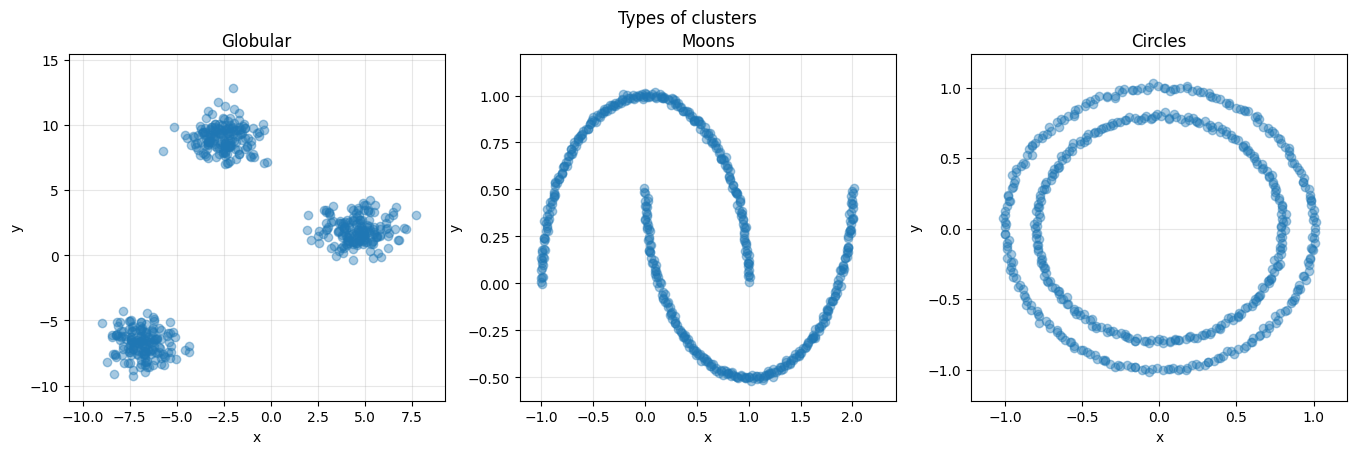

In [ ]:
plot_dfs([df_blobs, df_moons, df_circles])

In [ ]:
#add random points

#blobs
df_blobs = add_random_points(df_blobs, P_RANDOM_POINTS)

#moons
df_moons = add_random_points(df_moons, P_RANDOM_POINTS)

#circles
df_circles = add_random_points(df_circles, P_RANDOM_POINTS)

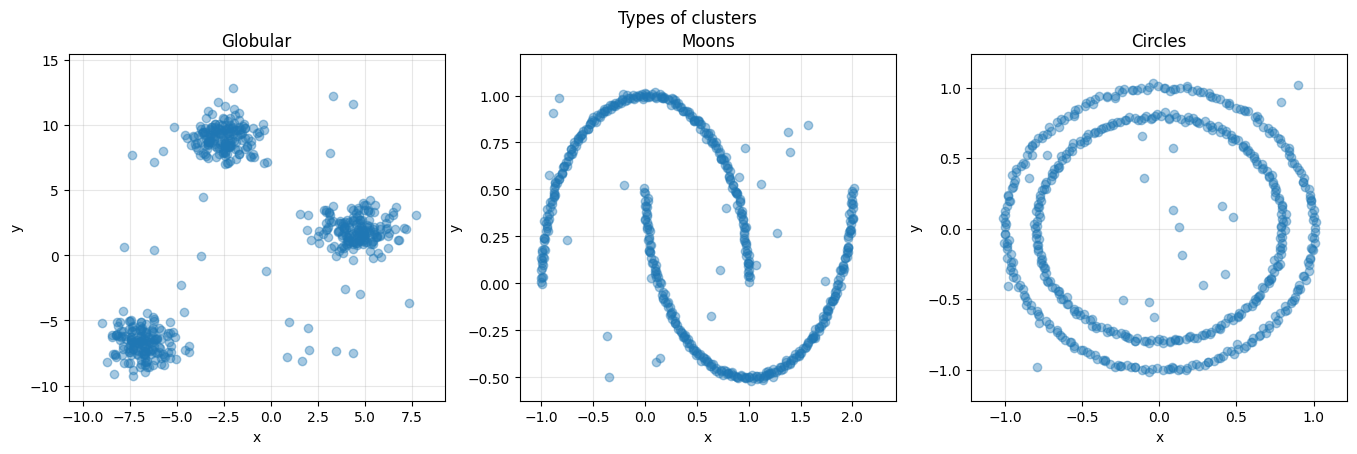

In [ ]:
plot_dfs([df_blobs, df_moons, df_circles])